### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

np.random.seed(0)
random.seed(0)

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
def Q_state(state):
    return ('-'.join(str(e) for e in state))

In [4]:
States_track = collections.defaultdict(dict)

In [5]:
# Below are the list of state-action pairs that are tracked for convergence
sample_q_values = [
    ((1, 2, 4), (1, 2)),
    ((1, 2, 4), (1, 3)),
    ((2, 10, 2), (2, 1))
]


# Initialise states-action dictonary to be tracked for convergence
def initialise_tracking_states():
    for q_values in sample_q_values:
        States_track[q_values[0]][q_values[1]] = []


initialise_tracking_states()

In [6]:
def save_tracking_states(env, agent, state_size):
    for state in States_track.keys():
        for action in States_track[state].keys():
            q_values = agent.model.predict(np.array(env.state_encod_arch1(state)).reshape(1, state_size))
            q_value = np.take(q_values[0], env.action_space.index(action))
            States_track[state][action].append(q_value)

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent():
    def __init__(self, environment, action_size, state_size, hyperparameter):
        # Define size of state and action
        self.environment = environment
        self.state_size = state_size
        self.action_size = action_size

        # hyper parameters for the DQN
        self.discount_factor = hyperparameter['discount_factor']
        self.learning_rate = hyperparameter['learning_rate']
        self.epsilon = hyperparameter['epsilon']
        self.epsilon_max = hyperparameter['epsilon_max']
        self.epsilon_decay = hyperparameter['epsilon_decay']
        self.epsilon_min = hyperparameter['epsilon_min']
        
        self.batch_size = hyperparameter['batch_size']     
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    
    def set_epsilon(self, episode):
        self.epsilon = self.epsilon_min + (
            self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay * episode)
        return self.epsilon

    def get_epsilon(self):
        return self.epsilon


    # approximate Q function using Neural Network
    def build_model(self):

        model = Sequential()

        # hidden layers
        model.add(Dense(36, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(36, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(36, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        (possible_actions_index, actions) = self.environment.requests(state)

        # 0.011
        if random.uniform(self.epsilon_max, 0.02) < self.get_epsilon(): 
            index = random.randrange(len(possible_actions_index))
            return (possible_actions_index[index], actions[index])

        else:
            state = np.array(self.environment.state_encod_arch1(state)).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            filter_q_value = np.take(q_value[0], possible_actions_index)
            
            if q_value[0][0] > np.max(filter_q_value):
                return (0, actions[-1])
            else:
                return (possible_actions_index[np.argmax(filter_q_value)], actions[np.argmax(filter_q_value)])


    def append_sample(self, state, action, reward, next_state, done):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, done))


    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """

        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)

            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = self.environment.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = self.environment.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)
            
            # for testing
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

#             # update the target values
#             for i in range(self.batch_size):
#                 if done[i]:
#                     target[i][actions[i]] = rewards[i]
#                 else: # non-terminal state
#                     target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

            return history.history['loss']

    def get_qvalue(self, state):
        state = np.array(self.environment.state_encod_arch1(state)).reshape(1, self.state_size)
        return self.model.predict(state)

    def save_model_weights(self, name):
        self.model.save_weights(name)


In [9]:
Episodes = 40000

max_car_drive_time = 30 * 24

Hyperparameters = {
    #'discount_factor': 0.95,
    'discount_factor': 0.5,
    'learning_rate' : 0.001,
    'epsilon': 1,
    'epsilon_max' : 1,
    'epsilon_decay' : 0.0003,
    'epsilon_min': 0.01,
    'batch_size' : 32
}

state_size = 36


env = CabDriver()
(action_space, _, _) = env.reset()

action_size = len(action_space)

agent = DQNAgent(environment= env, action_size= action_size, state_size= state_size, hyperparameter= Hyperparameters)

(rewards_per_episode, nn_loss_per_episode) = ([],[])

### DQN block

In [10]:
start_time = time.time()

for episode in range(1, Episodes + 1):
    
    done = False
    total_reward = 0
    agent_total_time = 0
    
    (_, _, curr_state) = env.reset()
    
    while not done:
        agent.set_epsilon(episode)
        
        (action_index, action) = agent.get_action(curr_state)
        
        (next_state, reward, total_worked_hours) = env.step(curr_state, action, Time_matrix)
        
        agent.append_sample(curr_state, action_index, reward, next_state, done)
        
        nn_loss = agent.train_model()

        total_reward += reward
        
        agent_total_time += total_worked_hours
        
        # debugging
        if episode == 30000 or episode == 29999:
            print('episode: {} state:{} actions:{} next_state:{} time:{} reward:{}'.format(
                episode, curr_state, action, next_state, agent_total_time, total_reward))
        
        curr_state = next_state
        
        if agent_total_time >= max_car_drive_time:
            done = True

    rewards_per_episode.append(total_reward)
    nn_loss_per_episode.append(nn_loss)
    save_tracking_states(env, agent, state_size)
    
    if episode % 1000 == 0:
        agent.save_model_weights(name="model_weights.h5")
    
    if episode % 500 == 0:
        print('Episdoe:{} Drive-Time:{} NN_loss:{} Reward:{} Epsilon:{}'.format(
            episode, agent_total_time, nn_loss, total_reward, agent.get_epsilon()))


save_obj(rewards_per_episode,'Rewards_per_Episode')
save_obj(nn_loss_per_episode,'NN_Loss_per_Episode')
save_obj(States_track,'States_track')

elapsed_time = time.time() - start_time
print(elapsed_time)

Episdoe:500 Drive-Time:726.0 NN_loss:[2.989792823791504] Reward:195.0 Epsilon:0.8621008966608072
Episdoe:1000 Drive-Time:720.0 NN_loss:[11.270868301391602] Reward:648.0 Epsilon:0.7434100384749007
Episdoe:1500 Drive-Time:726.0 NN_loss:[0.37499797344207764] Reward:879.0 Epsilon:0.6412518701055556
Episdoe:2000 Drive-Time:720.0 NN_loss:[0.2983852028846741] Reward:783.0 Epsilon:0.5533235197330862
Episdoe:2500 Drive-Time:721.0 NN_loss:[0.22758688032627106] Reward:985.0 Epsilon:0.4776428872136046
Episdoe:3000 Drive-Time:720.0 NN_loss:[4.345689296722412] Reward:1179.0 Epsilon:0.41250396314319315
Episdoe:3500 Drive-Time:721.0 NN_loss:[0.19056332111358643] Reward:1831.0 Epsilon:0.3564383716200439
Episdoe:4000 Drive-Time:723.0 NN_loss:[0.11822009831666946] Reward:1389.0 Epsilon:0.3081822697930801
Episdoe:4500 Drive-Time:729.0 NN_loss:[0.1881701648235321] Reward:1440.0 Epsilon:0.26664785803943264
Episdoe:5000 Drive-Time:729.0 NN_loss:[0.09174647927284241] Reward:1386.0 Epsilon:0.23089885854694558


episode: 29999 state:(3, 20, 1) actions:(3, 1) next_state:(1, 22, 1) time:326.0 reward:1007.0
episode: 29999 state:(1, 22, 1) actions:(1, 2) next_state:(2, 9, 2) time:337.0 reward:1051.0
episode: 29999 state:(2, 9, 2) actions:(2, 1) next_state:(1, 13, 2) time:341.0 reward:1067.0
episode: 29999 state:(1, 13, 2) actions:(4, 3) next_state:(3, 19, 2) time:347.0 reward:1091.0
episode: 29999 state:(3, 19, 2) actions:(1, 2) next_state:(2, 3, 3) time:355.0 reward:1114.0
episode: 29999 state:(2, 3, 3) actions:(2, 1) next_state:(1, 10, 3) time:362.0 reward:1142.0
episode: 29999 state:(1, 10, 3) actions:(1, 2) next_state:(2, 20, 3) time:372.0 reward:1182.0
episode: 29999 state:(2, 20, 3) actions:(2, 1) next_state:(1, 4, 4) time:380.0 reward:1214.0
episode: 29999 state:(1, 4, 4) actions:(1, 2) next_state:(2, 11, 4) time:387.0 reward:1242.0
episode: 29999 state:(2, 11, 4) actions:(0, 0) next_state:(2, 12, 4) time:388.0 reward:1237.0
episode: 29999 state:(2, 12, 4) actions:(2, 3) next_state:(3, 20, 

episode: 30000 state:(2, 23, 0) actions:(4, 3) next_state:(3, 4, 1) time:476.0 reward:1328.0
episode: 30000 state:(3, 4, 1) actions:(3, 2) next_state:(2, 10, 1) time:482.0 reward:1352.0
episode: 30000 state:(2, 10, 1) actions:(0, 0) next_state:(2, 11, 1) time:483.0 reward:1347.0
episode: 30000 state:(2, 11, 1) actions:(2, 0) next_state:(0, 17, 1) time:489.0 reward:1371.0
episode: 30000 state:(0, 17, 1) actions:(2, 1) next_state:(1, 7, 2) time:503.0 reward:1400.0
episode: 30000 state:(1, 7, 2) actions:(1, 4) next_state:(4, 14, 2) time:510.0 reward:1428.0
episode: 30000 state:(4, 14, 2) actions:(1, 0) next_state:(0, 20, 2) time:516.0 reward:1452.0
episode: 30000 state:(0, 20, 2) actions:(0, 4) next_state:(4, 3, 3) time:523.0 reward:1480.0
episode: 30000 state:(4, 3, 3) actions:(0, 1) next_state:(1, 8, 3) time:528.0 reward:1500.0
episode: 30000 state:(1, 8, 3) actions:(1, 4) next_state:(4, 14, 3) time:534.0 reward:1524.0
episode: 30000 state:(4, 14, 3) actions:(0, 3) next_state:(3, 19, 3)

### Tracking Convergence

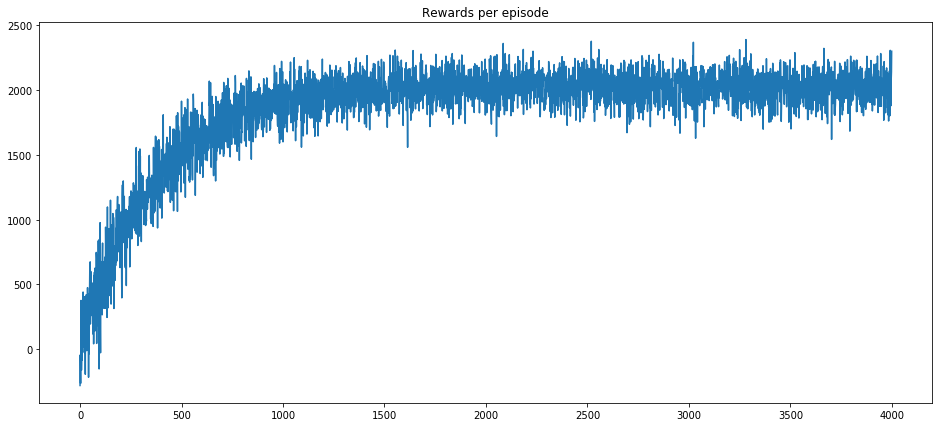

In [17]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_per_episode[::10])))
plt.plot(xaxis,np.asarray(rewards_per_episode[::10]))
plt.show()

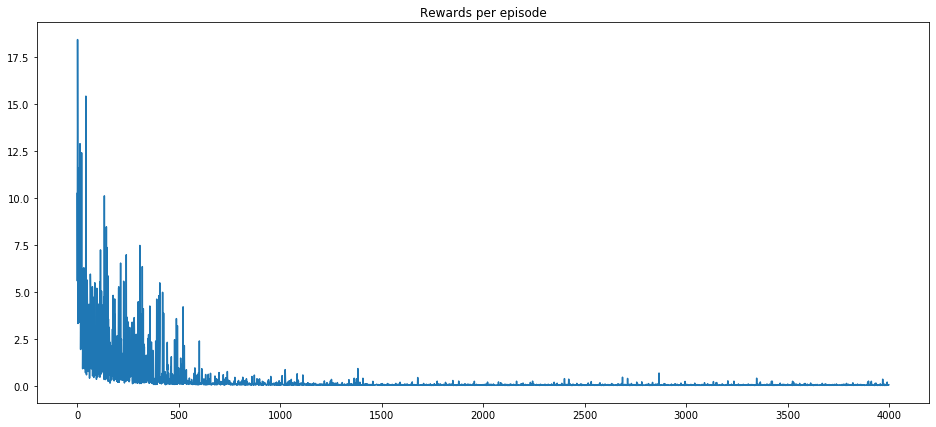

In [12]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(nn_loss_per_episode[::10])))
plt.plot(xaxis,np.asarray(nn_loss_per_episode[::10]))
plt.show()

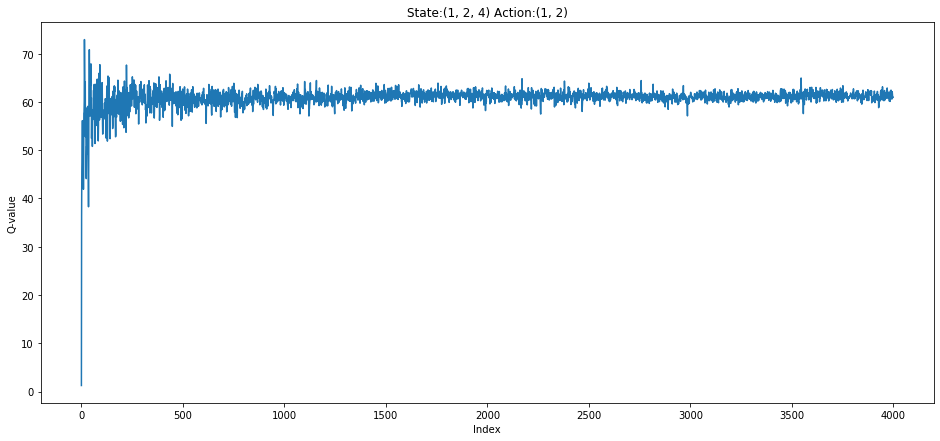

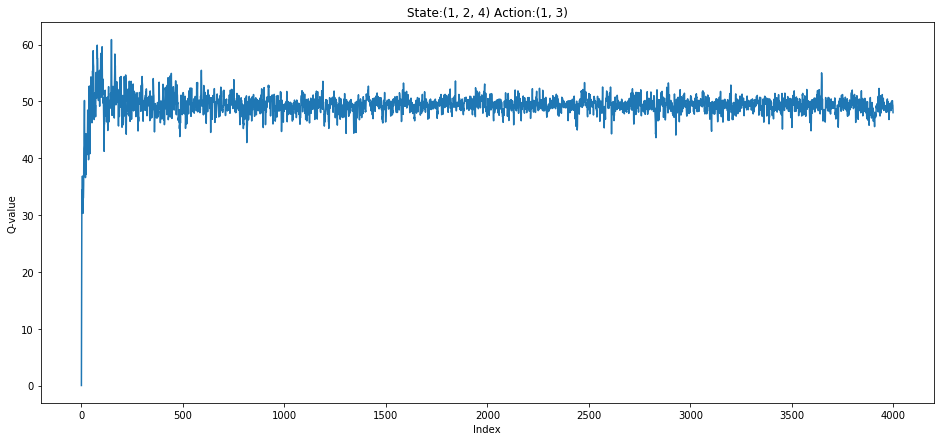

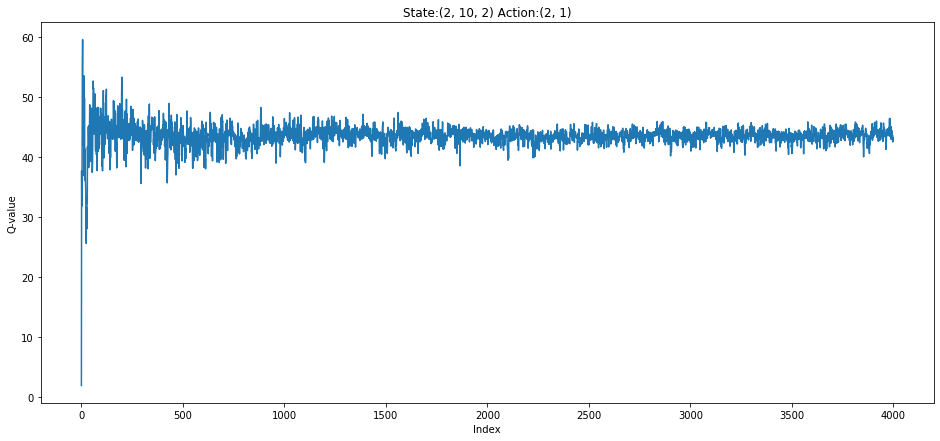

In [13]:

# Lets plot the convergence of Q-value state-action pair

plt.figure(0, figsize=(16,7))

# plot 1
plt.title('State:' + str(sample_q_values[0][0]) + ' ' +  'Action:' + str(sample_q_values[0][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[0][0]].get(sample_q_values[0][1])[::10]))),
    np.asarray(States_track[sample_q_values[0][0]].get(sample_q_values[0][1])[::10]))
plt.show()


# plot 2
plt.figure(0, figsize=(16,7))
plt.title('State:' + str(sample_q_values[1][0]) + ' ' +  'Action:' + str(sample_q_values[1][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[1][0]].get(sample_q_values[1][1])[::10]))),
    np.asarray(States_track[sample_q_values[1][0]].get(sample_q_values[1][1])[::10]))
plt.show()


# plot 3
plt.figure(0, figsize=(16,7))
plt.title('State:' + str(sample_q_values[2][0]) + ' ' +  'Action:' + str(sample_q_values[2][1]))
plt.xlabel('Index')
plt.ylabel('Q-value')
plt.plot(
    np.asarray(range(0, len(States_track[sample_q_values[2][0]].get(sample_q_values[2][1])[::10]))),
    np.asarray(States_track[sample_q_values[2][0]].get(sample_q_values[2][1])[::10]))
plt.show()



#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [14]:
time = np.arange(0,40000)
epsilon = []
for i in range(0,40000):
    epsilon.append(0 + (1 - 0.01) * np.exp(-0.0003*i))

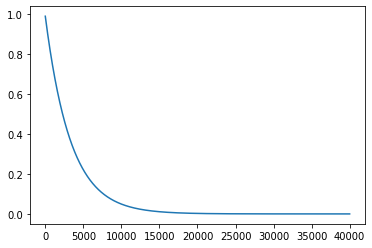

In [15]:
plt.plot(time, epsilon)
plt.show()